<a href="https://colab.research.google.com/github/KarynaSam/Python-DS/blob/main/HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
from concurrent.futures import ThreadPoolExecutor

%matplotlib inline

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


В домашньому завданні до даного модулю ви потренуєтесь робити тестове завдання для влаштування на роботу. За даними акселерометра з мобільного телефону потрібно класифікувати, якою діяльністю займається людина: йде, стоїть, біжить чи йде по сходах. Знайти датасет ви можете за посиланням.

Використайте алгоритми SVM та випадковий ліс з бібліотеки scikit-learn. Як характеристики можете брати показники з акселерометра, проте щоб покращити результати роботи алгоритмів, спочатку можна підготувати наш датасет і розрахувати часові ознаки (time domain features). Більше ці характеристики описані в даній статті.

Порівняйте результати роботи обох алгоритмів на різних фічах та різні моделі між собою.

In [13]:
merged_data = pd.DataFrame()

In [14]:
data_folder = '/content/drive/MyDrive/HW_5/data'

In [15]:
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                data = pd.read_csv(file_path)
                data['Activity'] = folder_name
                merged_data = pd.concat([merged_data, data], ignore_index=True)

In [16]:
merged_data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,-0.095768,0.177171,9.792285,idle
1,-0.086191,0.239420,9.777920,idle
2,-0.100556,0.234632,9.763555,idle
3,-0.067038,0.244209,9.773131,idle
4,-0.110133,0.229843,9.792285,idle


In [17]:
output_file = 'merged_data.csv'
merged_data.to_csv(output_file, index=False)

In [18]:
devices = pd.read_csv("merged_data.csv")

In [19]:
devices.shape


(194160, 4)

In [20]:
devices.head(10)


,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,-0.095768,0.177171,9.792285,idle
1,-0.086191,0.239420,9.777920,idle
2,-0.100556,0.234632,9.763555,idle
3,-0.067038,0.244209,9.773131,idle
4,-0.110133,0.229843,9.792285,idle
5,-0.105345,0.215478,9.782708,idle
6,-0.100556,0.225055,9.768343,idle
7,-0.100556,0.225055,9.753978,idle
8,-0.095768,0.225055,9.787497,idle
9,-0.110133,0.210690,9.758766,idle


In [21]:
devices.dtypes


accelerometer_X    float64
accelerometer_Y    float64
accelerometer_Z    float64
Activity            object
dtype: object

In [23]:
nulls = devices.iloc[:,1:].isnull().sum()/(len(devices.index)-1)
print("Empty cells\n")
print(nulls)

Empty cells

accelerometer_Y    0.0
accelerometer_Z    0.0
Activity           0.0
dtype: float64


In [24]:
scaler = StandardScaler()

accelerometer_columns = ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']
devices[accelerometer_columns] = scaler.fit_transform(devices[accelerometer_columns])
activities = listdir(data_folder)
devices.head(10)

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,-0.241151,-0.114828,1.110729,idle
1,-0.240012,-0.109840,1.108732,idle
2,-0.241720,-0.110224,1.106734,idle
3,-0.237735,-0.109457,1.108066,idle
4,-0.242859,-0.110608,1.110729,idle
5,-0.242290,-0.111759,1.109397,idle
6,-0.241720,-0.110991,1.107400,idle
7,-0.241720,-0.110991,1.105403,idle
8,-0.241151,-0.110991,1.110063,idle
9,-0.242859,-0.112142,1.106069,idle


Графічне представлення

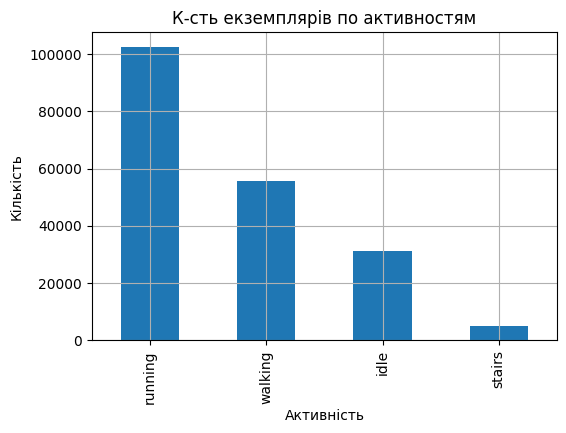

In [26]:
plt.figure(figsize=(6, 4))
activity_counts = devices['Activity'].value_counts()
activity_counts.plot(kind='bar')
plt.title('К-сть екземплярів по активностям')
plt.xlabel('Активність')
plt.ylabel('Кількість')
plt.grid()
plt.show()

In [27]:
grouped_data = devices.groupby('Activity').mean()


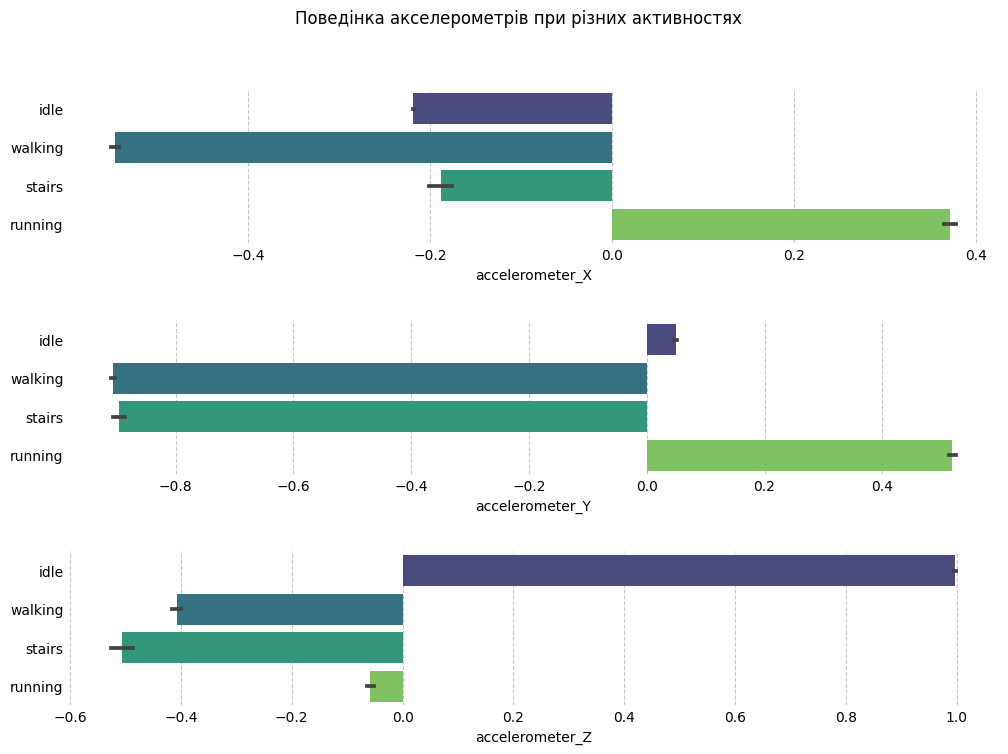

In [28]:
fig, axes = plt.subplots(3, figsize=(12, 8))
fig.suptitle('Поведінка акселерометрів при різних активностях')
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, col in enumerate(devices.columns):
    if col != 'Activity':
        sns.barplot(x=col, y='Activity', data=devices, ax=axes[i], palette='viridis')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('')
        axes[i].set_title('')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].tick_params(axis='both', length=0)
        axes[i].grid(axis='x', linestyle='--', alpha=0.7)
        axes[i].set_axisbelow(True)

plt.show()

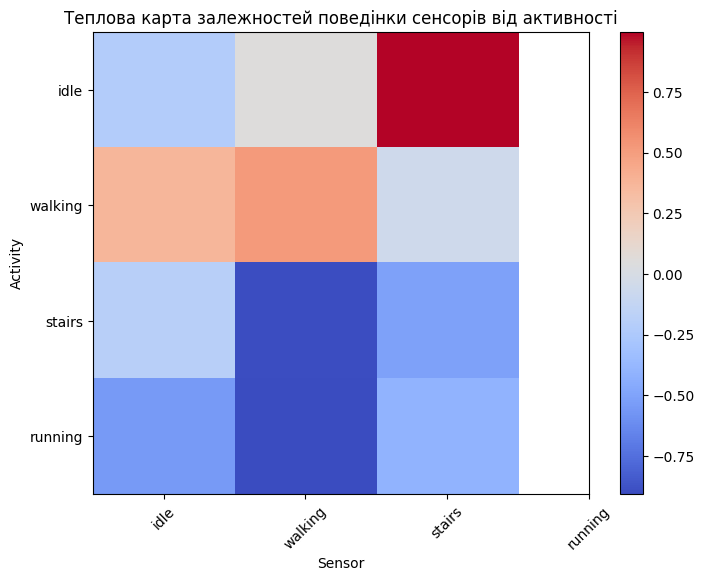

In [29]:
plt.figure(figsize=(8, 6))
plt.imshow(grouped_data, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(activities)), activities, rotation=45)
plt.yticks(range(len(activities)), activities)
plt.xlabel('Sensor')
plt.ylabel('Activity')
plt.title('Теплова карта залежностей поведінки сенсорів від активності')
plt.show()

**Побудова моделей та оцінка**

In [30]:
X = devices.drop('Activity', axis=1)
y = devices['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

***Побудова svm моделі та оцінка її результативності***

In [31]:
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8933868974042027
Precision: 0.8994653334925159
Recall: 0.8933868974042027
F1-score: 0.8830548033859695


Використання даної можелі займає 9 хв, та видається досить ресурсоємним при результатах менще 90%

***Побудова моделі випадковий ліс та оцінка її результативності***

In [32]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9996909765142151
Precision: 0.9996910934615366
Recall: 0.9996909765142151
F1-score: 0.9996903566667159


Дана модель швидша в три рази і в результаті дає показники близькі до 100% ефективності.

***Зчитування з одночасним мануальним побудуванням додаткових ознак***

1)Перевіряємо перелік активностей та кількість записів до кожної з них

In [33]:
data_folder = '/content/drive/MyDrive/HW_5/data'

activities = listdir(data_folder)

for activity in activities:
    path = join(data_folder, activity)
    frames = listdir(path)
    print(activity, " : ", len(frames))

idle  :  1039
walking  :  1850
stairs  :  165
running  :  3418


2)Задаємо список нових ознак які буде додано до дата сету

In [34]:
time_domain_features = ['skew_X', 'skew_Y', 'skew_Z', 'kurtosis_X', 'kurtosis_Y', 'kurtosis_Z', 'max_X', 'max_Y', 'max_Z',
                        'min_X', 'min_Y', 'min_Z', 'mean_X', 'mean_Y', 'mean_Z', 'std_X', 'std_Y', 'std_Z', 'variance_X', 'variance_Y', 'variance_Z',
                        'median_X', 'median_Y', 'median_Z', 'idxmax_X', 'idxmax_Y', 'idxmax_Z', 'idxmin_X', 'idxmin_Y', 'idxmin_Z',
                        'mae_X', 'mae_Y', 'mae_Z', 'rmse_X', 'rmse_Y', 'rmse_Z', 'corr_XY', 'corr_XZ', 'corr_YZ']

3)Будуємо функцію для додавання нових ознак при обробці чанків даних

In [35]:
def get_statistic_features(frame):
    features = []

    # Вычисление статистических признаков для каждой оси акселерометра
    for axis in ['X', 'Y', 'Z']:
        # Skew
        features.append(frame['accelerometer_' + axis].skew())

        # Kurtosis
        features.append(frame['accelerometer_' + axis].kurtosis())

        # Max
        features.append(frame['accelerometer_' + axis].max())

        # Min
        features.append(frame['accelerometer_' + axis].min())

        # Mean
        features.append(frame['accelerometer_' + axis].mean())

        # Standard Deviation
        features.append(frame['accelerometer_' + axis].std())

        # Variance
        features.append(frame['accelerometer_' + axis].var())

        # Median
        features.append(frame['accelerometer_' + axis].median())

        # Index of Maximum
        features.append(frame['accelerometer_' + axis].idxmax())

        # Index of Minimum
        features.append(frame['accelerometer_' + axis].idxmin())

        # Mean Absolute Error (MAE)
        features.append(np.abs(frame['accelerometer_' + axis] - frame['accelerometer_' + axis].mean()).mean())

        # Root Mean Squared Error (RMSE)
        features.append(np.sqrt(((frame['accelerometer_' + axis] - frame['accelerometer_' + axis].mean())**2).mean()))

    # Correlation between X and Y axes
    features.append(frame['accelerometer_X'].corr(frame['accelerometer_Y']))

    # Correlation between X and Z axes
    features.append(frame['accelerometer_X'].corr(frame['accelerometer_Z']))

    # Correlation between Y and Z axes
    features.append(frame['accelerometer_Y'].corr(frame['accelerometer_Z']))

    return features

4)Додаємо функцію процесінгу датасету зі зчитування даних та виклику попередньої фунції.

In [36]:
def process_data(data_folder, activities):
    columns = ['activity'] + time_domain_features
    features_list = []

    for activity in activities:
        path = join(data_folder, activity)
        frames = listdir(path)

        for frame_file in frames:
            frame = pd.read_csv(join(path, frame_file))
            features = get_statistic_features(frame)
            features_list.append([activity] + features)

    df = pd.DataFrame(features_list, columns=columns)
    return df

df = process_data(data_folder, activities)
df.shape

(6472, 40)

5) Записуємо дані

In [37]:
output_file = 'manual_engeneered_data.csv'
df.to_csv(output_file, index=False)

In [38]:
engeneered_devices = pd.read_csv("manual_engeneered_data.csv")

engeneered_devices.head(10)

,activity,skew_X,skew_Y,skew_Z,kurtosis_X,kurtosis_Y,kurtosis_Z,max_X,max_Y,max_Z,...,idxmin_Z,mae_X,mae_Y,mae_Z,rmse_X,rmse_Y,rmse_Z,corr_XY,corr_XZ,corr_YZ
0,idle,2.560821,7.289308,0.023942,-0.138864,-0.095928,0.035333,0.001248,-0.102950,25,...,0.022406,0.000502,9.765949,20,25,0.017079,0.022030,-0.267274,-0.546663,0.133007
1,idle,2.488650,6.958863,0.023942,-0.138864,-0.097204,0.036013,0.001297,-0.105345,23,...,0.022093,0.000488,9.765949,18,23,0.016759,0.021722,-0.193842,-0.561361,0.161127
2,idle,-4.147484,20.070676,0.023942,-0.770933,-0.129766,0.132732,0.017618,-0.105345,19,...,0.069053,0.004768,9.765949,29,28,0.031486,0.067893,0.897061,-0.641958,-0.780538
3,idle,-1.287826,6.091654,1.747767,-2.896984,0.152112,0.821458,0.674793,-0.028730,28,...,1.708309,2.918319,9.715670,15,17,1.286931,1.679596,0.767360,0.012923,-0.473325
4,idle,-2.967217,14.436298,0.967258,-2.896984,-0.093374,0.626266,0.392209,-0.098162,24,...,1.462022,2.137507,9.761161,21,23,0.896123,1.437448,0.617454,0.520942,-0.268657
5,idle,-3.561508,18.237259,0.967258,-2.896984,-0.162167,0.580932,0.337482,-0.105345,28,...,1.368715,1.873381,9.763555,25,27,0.604041,1.345710,0.676064,0.742925,0.064550
6,idle,-4.964946,25.733830,0.028730,-2.896984,-0.218670,0.523737,0.274300,-0.107739,28,...,1.335834,1.784452,9.765949,27,29,0.470849,1.313381,0.964165,0.956821,0.872260
7,idle,-3.339482,16.678003,0.967258,-2.896984,-0.132798,0.598359,0.358034,-0.105345,26,...,1.439054,2.070877,9.763555,23,25,0.796205,1.414867,0.584134,0.614505,-0.202310
8,idle,-2.309678,10.047750,1.077391,-2.896984,0.030167,0.703398,0.494769,-0.088585,27,...,1.545241,2.387770,9.749189,17,19,1.116113,1.519269,0.714301,0.280559,-0.400119
9,idle,-2.471678,11.510968,1.077391,-2.896984,-0.029050,0.672208,0.451863,-0.093374,29,...,1.496591,2.239785,9.749189,19,21,1.003458,1.471437,0.678000,0.388353,-0.332866


6) Перевіримо список ознак

In [39]:
print(engeneered_devices.columns.tolist())


['activity', 'skew_X', 'skew_Y', 'skew_Z', 'kurtosis_X', 'kurtosis_Y', 'kurtosis_Z', 'max_X', 'max_Y', 'max_Z', 'min_X', 'min_Y', 'min_Z', 'mean_X', 'mean_Y', 'mean_Z', 'std_X', 'std_Y', 'std_Z', 'variance_X', 'variance_Y', 'variance_Z', 'median_X', 'median_Y', 'median_Z', 'idxmax_X', 'idxmax_Y', 'idxmax_Z', 'idxmin_X', 'idxmin_Y', 'idxmin_Z', 'mae_X', 'mae_Y', 'mae_Z', 'rmse_X', 'rmse_Y', 'rmse_Z', 'corr_XY', 'corr_XZ', 'corr_YZ']


***Виконаємо графічне представлення***

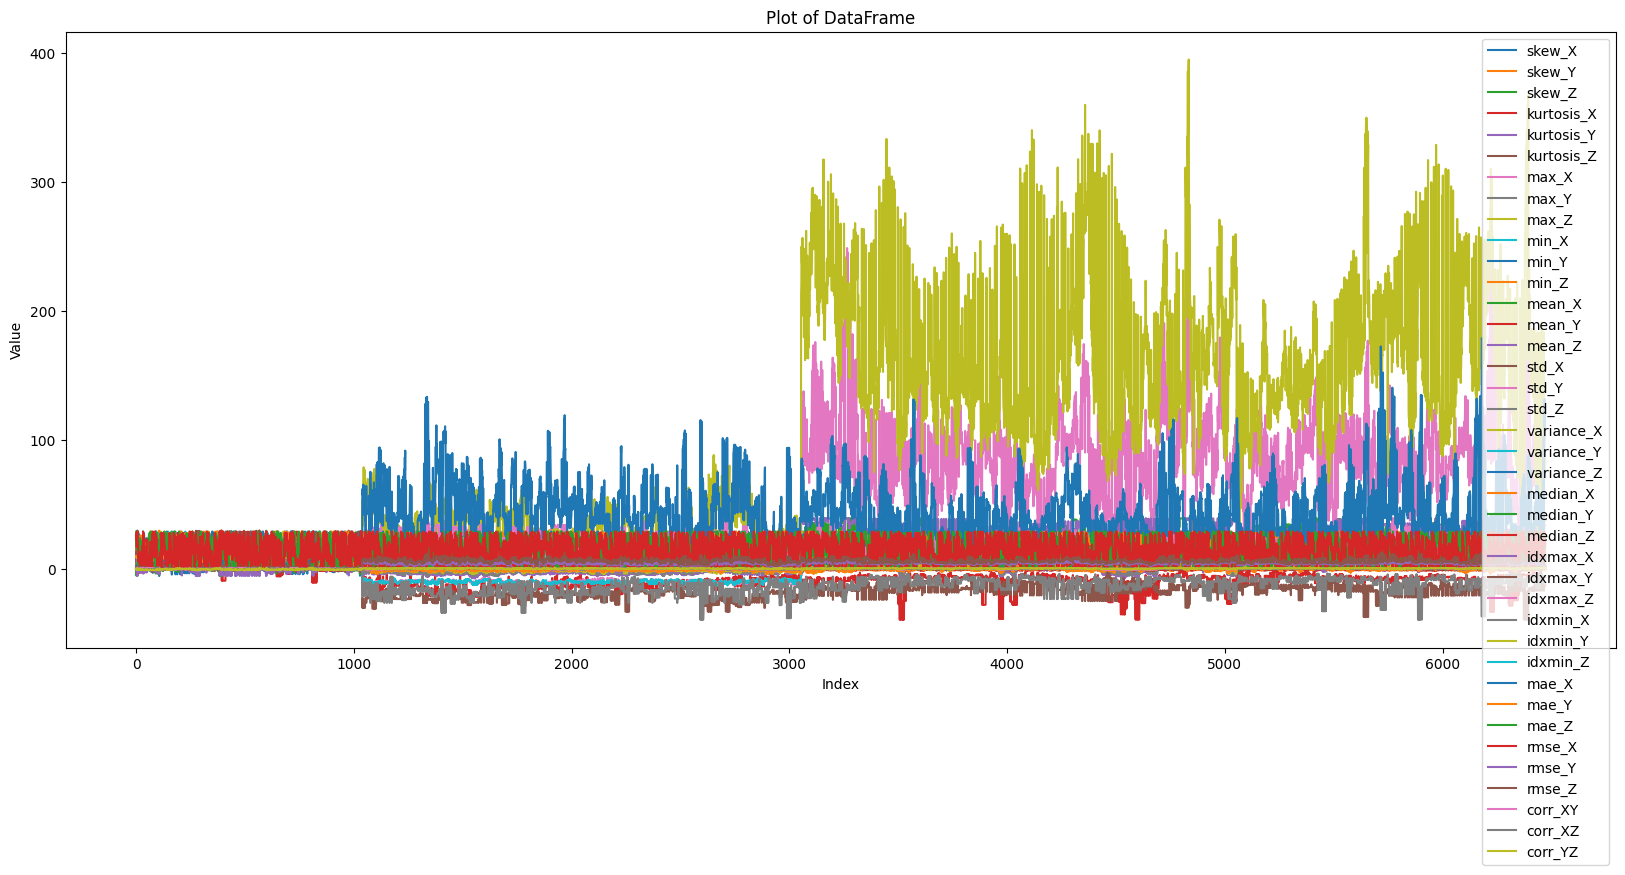

In [40]:
engeneered_devices.plot(figsize=(20, 8))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of DataFrame')
plt.show()

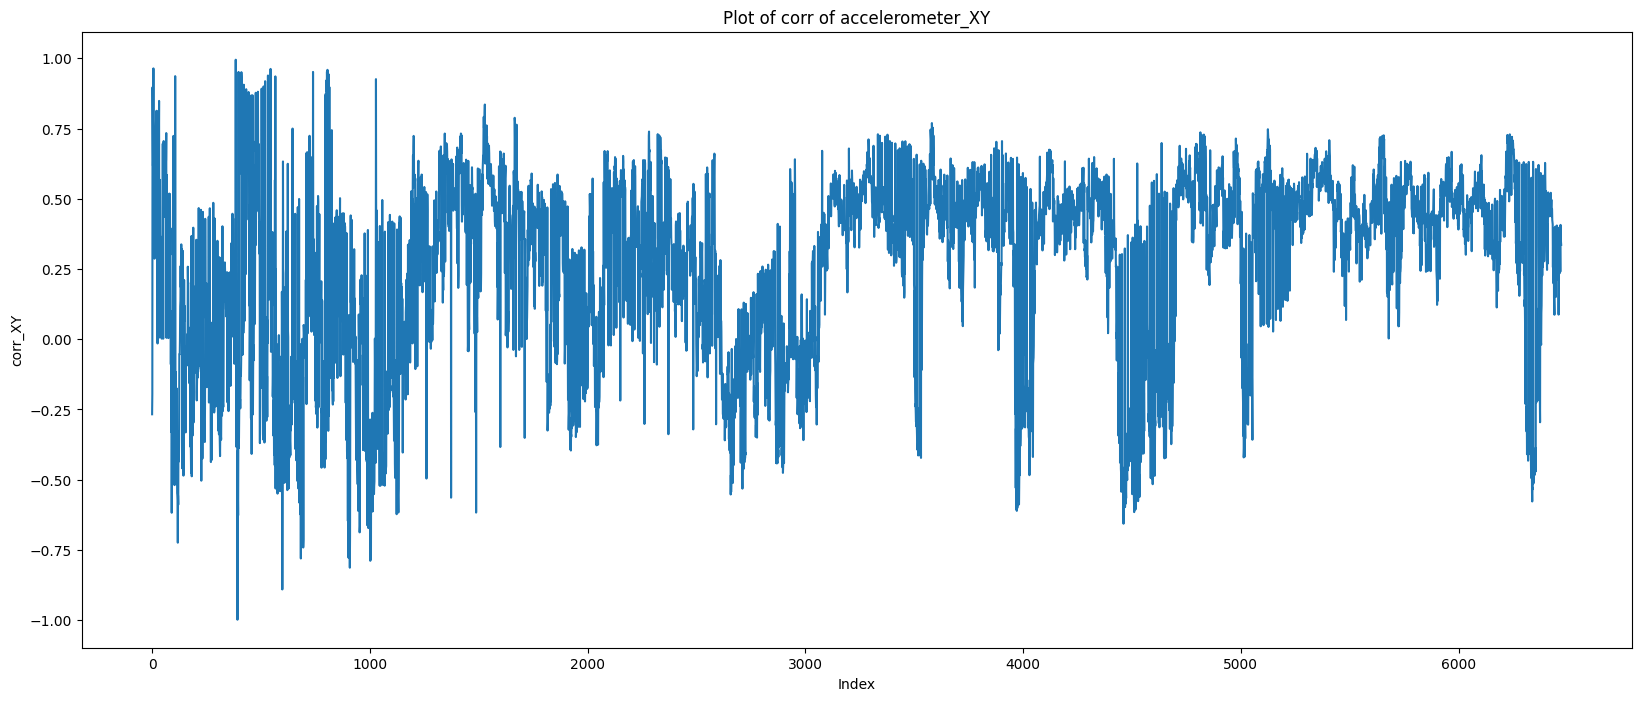

In [41]:
plt.figure(figsize=(20, 8))
plt.plot(engeneered_devices['corr_XY'])
plt.xlabel('Index')
plt.ylabel('corr_XY')
plt.title('Plot of corr of accelerometer_XY')
plt.show()

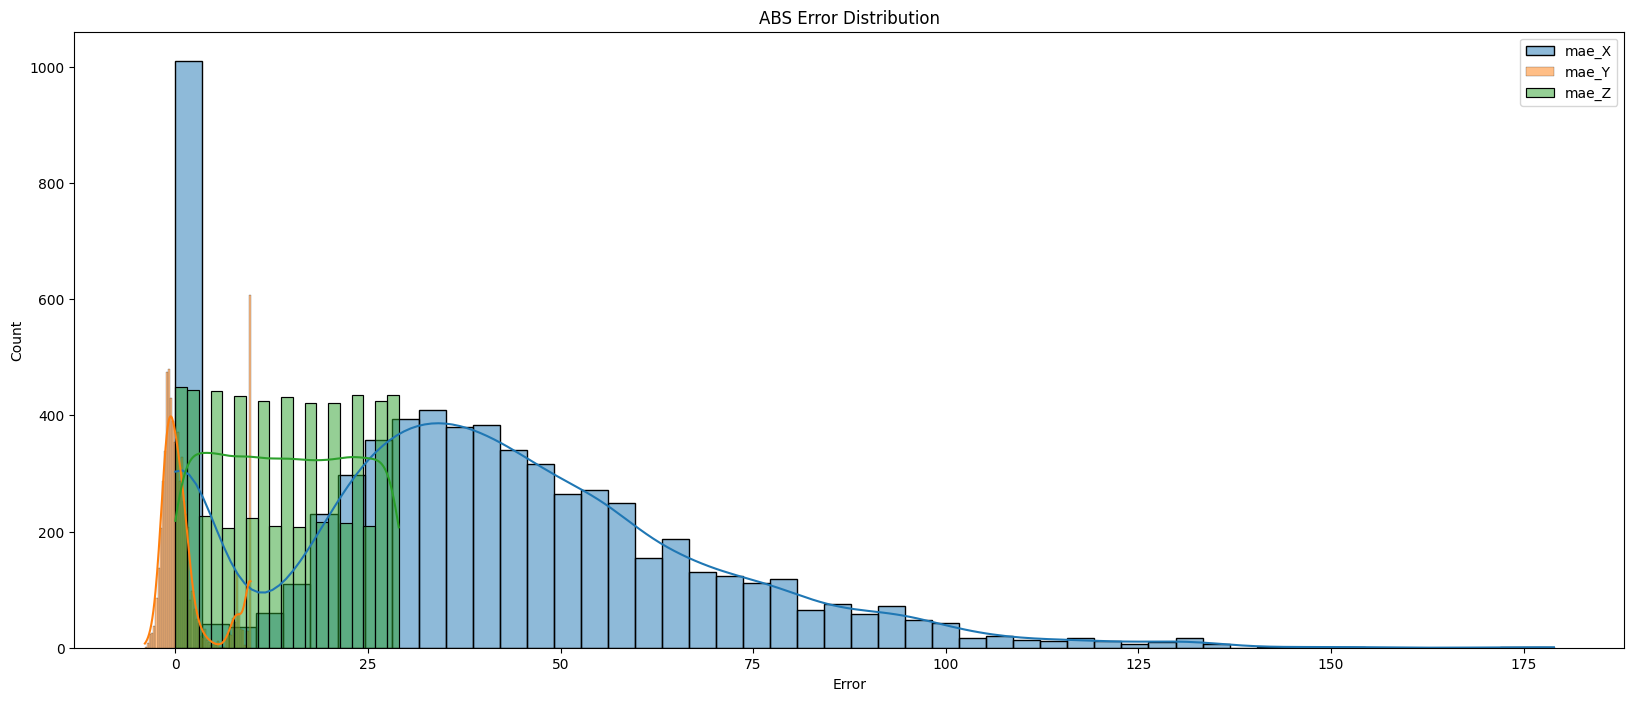

In [42]:
error_cols = ['mae_X', 'mae_Y', 'mae_Z']

# Графік розподілу помилок
plt.figure(figsize=(20, 8))
for col in error_cols:
    sns.histplot(engeneered_devices[col], kde=True, label=col)

plt.xlabel('Error')
plt.ylabel('Count')
plt.title('ABS Error Distribution')
plt.legend()
plt.show()

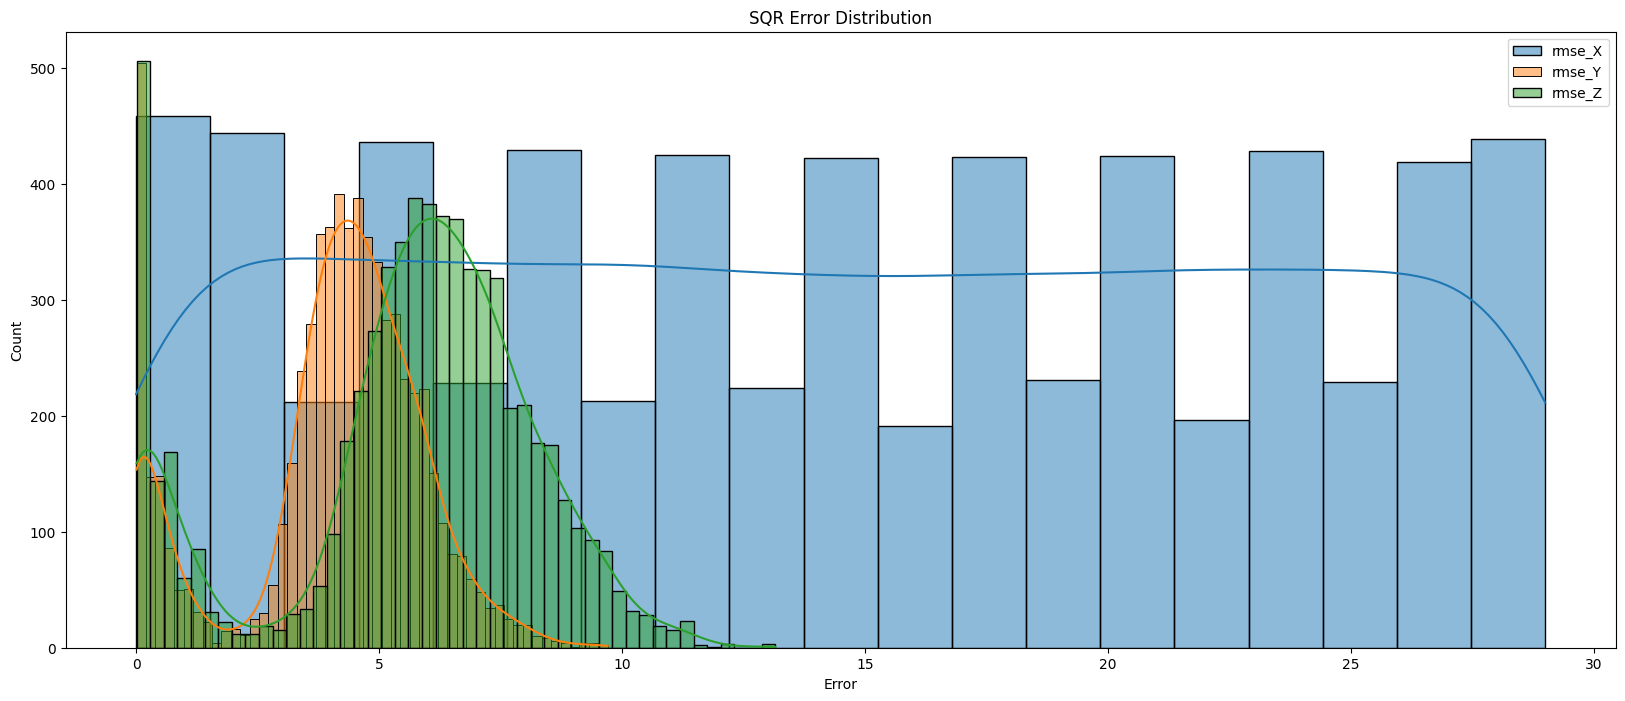

In [43]:
error_cols = ['rmse_X', 'rmse_Y', 'rmse_Z']

plt.figure(figsize=(20, 8))
for col in error_cols:
    sns.histplot(engeneered_devices[col], kde=True, label=col)

plt.xlabel('Error')
plt.ylabel('Count')
plt.title('SQR Error Distribution')
plt.legend()
plt.show()

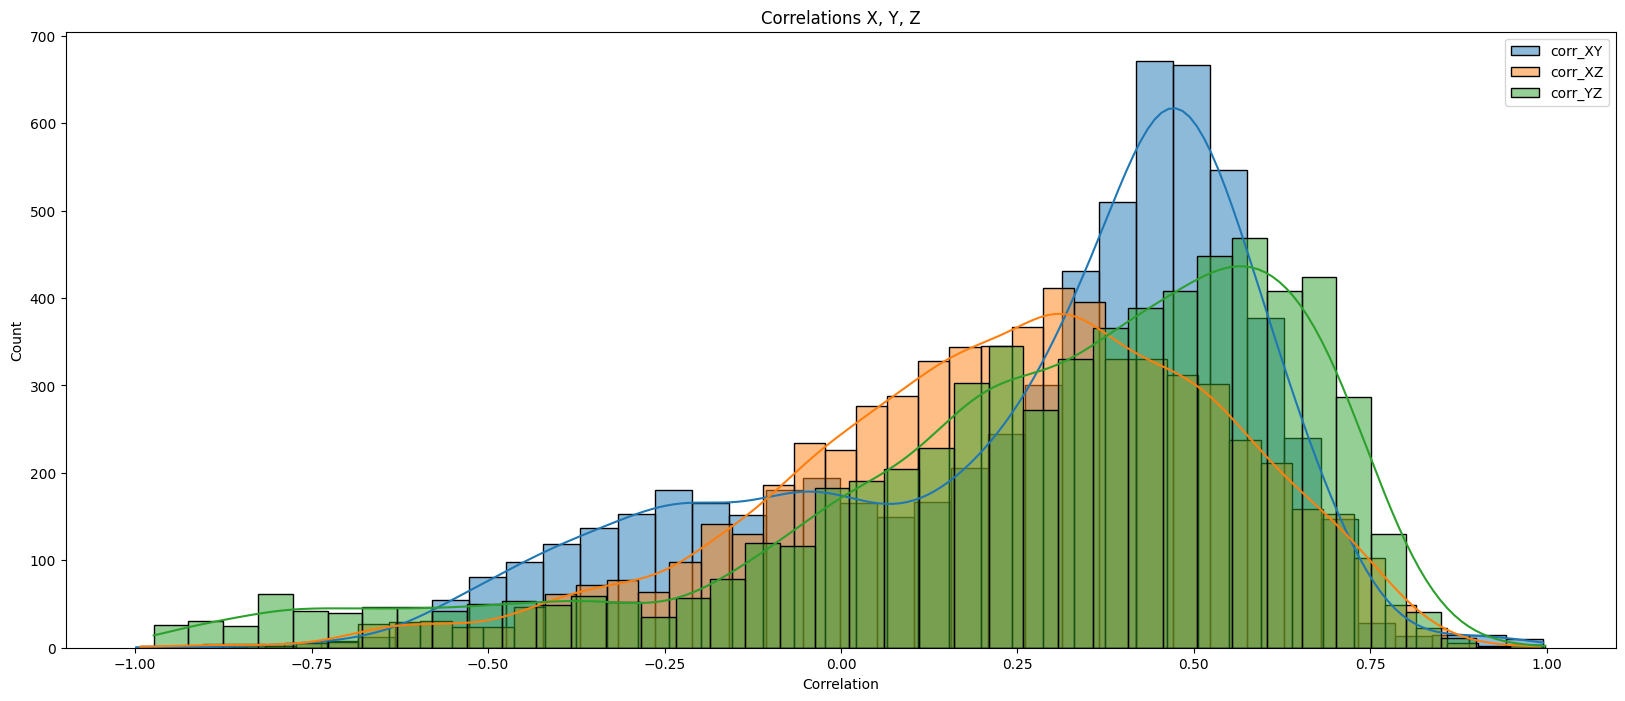

In [44]:
error_cols = ['corr_XY', 'corr_XZ', 'corr_YZ']

plt.figure(figsize=(20, 8))
for col in error_cols:
    sns.histplot(engeneered_devices[col], kde=True, label=col)

plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('Correlations X, Y, Z')
plt.legend()
plt.show()

***Побудова нерегулюємих моделей SVM та RandomForest та їх аналіз***

In [45]:
X = engeneered_devices.drop('activity', axis=1)
y = engeneered_devices['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
# Модель SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("Accuracy (SVM):", accuracy_svm)
print("Precision (SVM):", precision_svm)
print("Recall (SVM):", recall_svm)
print("F1-score (SVM):", f1_svm)

# Модель RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("\nAccuracy (RandomForest):", accuracy_rf)
print("Precision (RandomForest):", precision_rf)
print("Recall (RandomForest):", recall_rf)
print("F1-score (RandomForest):", f1_rf)

Accuracy (SVM): 0.9953667953667954
Precision (SVM): 0.9953667953667954
Recall (SVM): 0.9953667953667954
F1-score (SVM): 0.9953667953667954

Accuracy (RandomForest): 1.0
Precision (RandomForest): 1.0
Recall (RandomForest): 1.0
F1-score (RandomForest): 1.0


Як висновок побудова обох моделей на зінженірених даних відпрацювали однаково швидко з високими показниками ефективності.

***Побудова регулюємих моделей SVM та RandomForest***

In [47]:
# Списки параметрів для моделей
svm_params = [{'kernel': 'linear'}, {"C": 10, 'kernel': 'linear'}, {'kernel': 'rbf', 'gamma': 0.1},
              {'kernel': 'rbf', 'gamma': 0.01},  {'kernel': 'poly', 'degree': 2}, {'kernel': 'poly', 'degree': 5}]
rf_params = [{'n_estimators': 100, 'max_depth': 10}, {'n_estimators': 200, 'max_depth': 10}, {'n_estimators': 200, 'max_depth': 20},
             {'n_estimators': 200, 'max_depth': 30}, {'n_estimators': 300, 'max_depth': 30}, {'n_estimators': 300, 'max_depth': 5}]

In [48]:
# Цикл для навчання та оцінки моделей з різними параметрами
for svm_param in svm_params:
    svm_model = SVC(**svm_param, probability=True)
    svm_model.fit(X_train, y_train)

    y_pred_svm = svm_model.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=1)
    recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=1)

    f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

    print("\nSVM Parameters:", svm_param)
    print("Accuracy (SVM):", accuracy_svm)
    print("Precision (SVM):", precision_svm)
    print("Recall (SVM):", recall_svm)
    print("Overfitting check F1-score: ", "train:", f1_score(y_train, svm_model.predict(X_train), average='weighted'), "test:", f1_svm)



SVM Parameters: {'kernel': 'linear'}
Accuracy (SVM): 0.9953667953667954
Precision (SVM): 0.9953667953667954
Recall (SVM): 0.9953667953667954
Overfitting check F1-score:  train: 0.996473441908462 test: 0.9953667953667954

SVM Parameters: {'C': 10, 'kernel': 'linear'}
Accuracy (SVM): 0.9976833976833976
Precision (SVM): 0.9977267285732135
Recall (SVM): 0.9976833976833976
Overfitting check F1-score:  train: 0.9982524303757226 test: 0.9976991183704572

SVM Parameters: {'kernel': 'rbf', 'gamma': 0.1}
Accuracy (SVM): 0.5281853281853282
Precision (SVM): 0.7507944127249147
Recall (SVM): 0.5281853281853282
Overfitting check F1-score:  train: 1.0 test: 0.3651124451528696

SVM Parameters: {'kernel': 'rbf', 'gamma': 0.01}
Accuracy (SVM): 0.8957528957528957
Precision (SVM): 0.9129364843650558
Recall (SVM): 0.8957528957528957
Overfitting check F1-score:  train: 1.0 test: 0.8926272446126586

SVM Parameters: {'kernel': 'poly', 'degree': 2}
Accuracy (SVM): 0.972972972972973
Precision (SVM): 0.975308641

In [49]:
for rf_param in rf_params:
    rf_model = RandomForestClassifier(random_state=42, **rf_param)
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
    recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
    f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
    #auc_roc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test), multi_class='ovr')
    auc_prc_rf = []
    for i in range(len(rf_model.classes_)):
        class_scores = rf_model.predict_proba(X_test)[:, i]
        class_labels = np.where(y_test == rf_model.classes_[i], 1, 0)
        auc_prc = average_precision_score(class_labels, class_scores)
        auc_prc_rf.append(auc_prc)



    print("\nRandomForest Parameters:", rf_param)
    print("Accuracy (RandomForest):", accuracy_rf)
    print("Precision (RandomForest):", precision_rf)
    print("Recall (RandomForest):", recall_rf)
    #print("AUC-ROC:", auc_roc_rf)
    print("AUC-PRC:", auc_prc_rf)
    print("Overfitting check F1-score: ", "train:", f1_score(y_train, rf_model.predict(X_train), average='weighted'), "test:", f1_rf)


RandomForest Parameters: {'n_estimators': 100, 'max_depth': 10}
Accuracy (RandomForest): 0.9976833976833976
Precision (RandomForest): 0.9977020298736116
Recall (RandomForest): 0.9976833976833976
AUC-PRC: [1.0, 1.0, 0.9972434910603359, 0.9999782624447504]
Overfitting check F1-score:  train: 0.9988287234571451 test: 0.9976329173406658

RandomForest Parameters: {'n_estimators': 200, 'max_depth': 10}
Accuracy (RandomForest): 0.9976833976833976
Precision (RandomForest): 0.9977020298736116
Recall (RandomForest): 0.9976833976833976
AUC-PRC: [1.0, 1.0, 0.9981904607573057, 0.9999854693403081]
Overfitting check F1-score:  train: 0.999221929655121 test: 0.9976329173406658

RandomForest Parameters: {'n_estimators': 200, 'max_depth': 20}
Accuracy (RandomForest): 1.0
Precision (RandomForest): 1.0
Recall (RandomForest): 1.0
AUC-PRC: [1.0, 1.0, 1.0, 1.0]
Overfitting check F1-score:  train: 1.0 test: 1.0

RandomForest Parameters: {'n_estimators': 200, 'max_depth': 30}
Accuracy (RandomForest): 1.0
Prec

Висновок: при побудові декількох варіантів для кожної моделі бачимо що:

метод опорних векторів справляється гірше (6 моделей - 1 хв.):

*   на RBF kernel - f1 від 0,3 до 0,9, та спостерігається перенавчання
*   на polynomial kernel - f1 від 0,94 до 0,95, перенавчання відсутнє
*   найкращі результати у лінійної моделі - f1 від 0,996 до 0,998, перенавчання майже відсутнє

метод випадкового лісу при різноманітних параметрах показав найбільшу ефективність (6 моделей - 15 сек) - f1 від 0,987 до 0,999, при змінах параметрів спостерігається деяке перенавчання